In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import pandas as pd
import os
from PIL import Image
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_DIR = 'data/processed_pngs'
BATCH_SIZE = 16

In [3]:
class RSNADataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, img_name)
        label = int(self.data.iloc[idx]['Target'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
test_dataset = RSNADataset('data/test_split.csv', IMG_DIR, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
latency_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [6]:
def get_model_size_mb(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    return (param_size + buffer_size) / 1024**2

In [7]:
def evaluate_model(model, loader, device):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    end_time = time.time()
    
    acc = accuracy_score(all_labels, all_preds)
    latency = (end_time - start_time) / len(loader.dataset) * 1000
    
    return acc, latency

In [8]:
teacher = models.resnet50(weights=None)
teacher.fc = nn.Linear(teacher.fc.in_features, 2)
teacher.load_state_dict(torch.load("teacher_resnet50.pth", map_location=DEVICE))

baseline = models.mobilenet_v3_small(weights=None)
baseline.classifier[3] = nn.Linear(baseline.classifier[3].in_features, 2)
baseline.load_state_dict(torch.load("baseline_mobilenet.pth", map_location=DEVICE))

student = models.mobilenet_v3_small(weights=None)
student.classifier[3] = nn.Linear(student.classifier[3].in_features, 2)
student.load_state_dict(torch.load("nanoray_student.pth", map_location=DEVICE))

<All keys matched successfully>

In [9]:
student.to('cpu')
student.eval()
quantized_student = torch.quantization.quantize_dynamic(
    student, {nn.Linear, nn.Conv2d}, dtype=torch.qint8
)

            Model   Size(MB)  Accuracy  Latency(ms)
0         Teacher  89.894699  0.831772    15.295271
1        Baseline   5.844444  0.831023     3.462908
2         NanoRay   5.844444  0.841514     3.678688
3  NanoRay (INT8)   3.582718  0.841514    12.797648


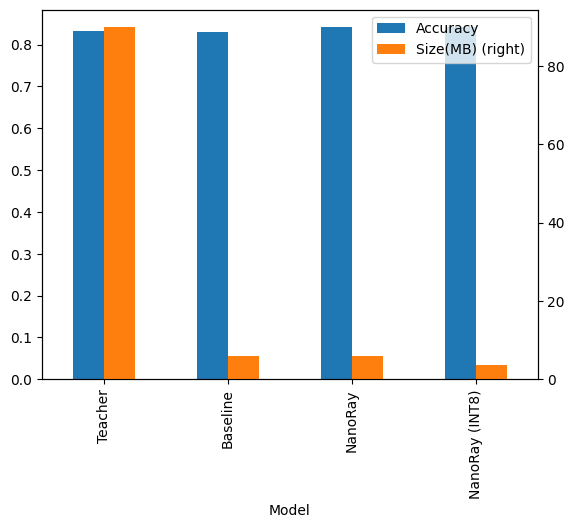

In [10]:
results = []

t_acc, t_lat = evaluate_model(teacher, test_loader, DEVICE)
results.append(["Teacher", get_model_size_mb(teacher), t_acc, t_lat])

b_acc, b_lat = evaluate_model(baseline, test_loader, DEVICE)
results.append(["Baseline", get_model_size_mb(baseline), b_acc, b_lat])

s_acc, s_lat = evaluate_model(student, test_loader, DEVICE)
results.append(["NanoRay", get_model_size_mb(student), s_acc, s_lat])

q_acc, q_lat = evaluate_model(quantized_student, latency_loader, 'cpu')
results.append(["NanoRay (INT8)", get_model_size_mb(quantized_student), q_acc, q_lat])

df = pd.DataFrame(results, columns=["Model", "Size(MB)", "Accuracy", "Latency(ms)"])
print(df)

df.plot(x="Model", y=["Accuracy", "Size(MB)"], kind="bar", secondary_y="Size(MB)")
plt.show()